In [26]:
# Import required libraries
import pandas as pd
import random
import numpy as np
from typing import List, Tuple, Union, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [27]:
def initialize_players(num_players: int) -> pd.DataFrame:
    """
    Create a DataFrame with N unique placeholder players.
    
    Args:
        num_players: Number of players to create
        
    Returns:
        DataFrame with player data initialized
    """
    players_data = {
        'player_id': range(1, num_players + 1),
        'match_points': [0] * num_players,
        'wins': [0] * num_players,
        'losses': [0] * num_players,
        'ties': [0] * num_players,
        'opponents_played': [set() for _ in range(num_players)],
        'received_bye': [False] * num_players,
        'is_active': [True] * num_players
    }
    
    return pd.DataFrame(players_data)

# Test the function
test_players = initialize_players(10)
print("Sample player data:")
print(test_players.head())


Sample player data:
   player_id  match_points  wins  losses  ties opponents_played  received_bye  \
0          1             0     0       0     0               {}         False   
1          2             0     0       0     0               {}         False   
2          3             0     0       0     0               {}         False   
3          4             0     0       0     0               {}         False   
4          5             0     0       0     0               {}         False   

   is_active  
0       True  
1       True  
2       True  
3       True  
4       True  


In [28]:
def simulate_match(player1_id: int, player2_id: int, global_tie_rate: float = 0.15) -> str:
    """
    Simulate a match between two players with random outcomes.
    
    Args:
        player1_id: ID of first player
        player2_id: ID of second player
        global_tie_rate: Probability of a tie (default 0.15)
        
    Returns:
        Match outcome: 'player1_wins', 'player2_wins', or 'tie'
    """
    outcome_prob = random.random()
    
    if outcome_prob < global_tie_rate:
        return 'tie'
    elif outcome_prob < global_tie_rate + (1 - global_tie_rate) / 2:
        return 'player1_wins'
    else:
        return 'player2_wins'

# Test the function
print("Testing match outcomes:")
for i in range(10):
    result = simulate_match(1, 2, 0.15)
    print(f"Match {i+1}: {result}")
    
# Test distribution over many matches
outcomes = [simulate_match(1, 2, 0.15) for _ in range(1000)]
print(f"\nOutcome distribution over 1000 matches:")
print(f"Player 1 wins: {outcomes.count('player1_wins')/10:.1f}%")
print(f"Player 2 wins: {outcomes.count('player2_wins')/10:.1f}%")
print(f"Ties: {outcomes.count('tie')/10:.1f}%")


Testing match outcomes:
Match 1: player2_wins
Match 2: tie
Match 3: player1_wins
Match 4: player1_wins
Match 5: player2_wins
Match 6: player2_wins
Match 7: player2_wins
Match 8: tie
Match 9: player1_wins
Match 10: tie

Outcome distribution over 1000 matches:
Player 1 wins: 42.4%
Player 2 wins: 44.2%
Ties: 13.4%


In [29]:
def pair_round(players_df: pd.DataFrame) -> List[Tuple[Union[int, str], Union[int, str]]]:
    """
    Create Swiss pairings for the current round.
    
    Args:
        players_df: DataFrame of active players
        
    Returns:
        List of pairings: [(player1_id, player2_id), ...] or [(player_id, 'BYE'), ...]
    """
    # Filter active players and sort by match points (descending), then by player_id
    active_players = players_df[players_df['is_active']].copy()
    active_players = active_players.sort_values(['match_points', 'player_id'], 
                                               ascending=[False, True])
    
    pairings = []
    paired_players = set()
    
    player_list = active_players['player_id'].tolist()
    
    # Pair players
    i = 0
    while i < len(player_list):
        if player_list[i] in paired_players:
            i += 1
            continue
            
        player1_id = player_list[i]
        player1_opponents = active_players[active_players['player_id'] == player1_id]['opponents_played'].iloc[0]
        
        # Find a valid opponent
        paired = False
        for j in range(i + 1, len(player_list)):
            player2_id = player_list[j]
            if player2_id in paired_players:
                continue
                
            # Check if they've played before
            if player2_id not in player1_opponents:
                pairings.append((player1_id, player2_id))
                paired_players.add(player1_id)
                paired_players.add(player2_id)
                paired = True
                break
        
        # If no valid opponent found, pair with next available (allowing rematch if necessary)
        if not paired:
            for j in range(i + 1, len(player_list)):
                player2_id = player_list[j]
                if player2_id not in paired_players:
                    pairings.append((player1_id, player2_id))
                    paired_players.add(player1_id)
                    paired_players.add(player2_id)
                    paired = True
                    break
        
        # If still not paired and no more players, give bye
        if not paired:
            pairings.append((player1_id, 'BYE'))
            paired_players.add(player1_id)
            paired = True
        
        i += 1
    
    return pairings

# Test pairing function
test_players = initialize_players(7)  # Odd number to test bye
test_pairings = pair_round(test_players)
print("Test pairings for 7 players:")
for pairing in test_pairings:
    print(f"  {pairing}")


Test pairings for 7 players:
  (1, 2)
  (3, 4)
  (5, 6)
  (7, 'BYE')


In [30]:
def update_player_stats(players_df: pd.DataFrame, player_id: int, 
                        match_points: int, wins: int = 0, losses: int = 0, ties: int = 0,
                        opponent_id: int = None, received_bye: bool = False):
    """Update player statistics after a match or bye."""
    idx = players_df[players_df['player_id'] == player_id].index[0]
    
    players_df.at[idx, 'match_points'] += match_points
    players_df.at[idx, 'wins'] += wins
    players_df.at[idx, 'losses'] += losses
    players_df.at[idx, 'ties'] += ties
    
    if opponent_id is not None:
        players_df.at[idx, 'opponents_played'].add(opponent_id)
    
    if received_bye:
        players_df.at[idx, 'received_bye'] = True

def simulate_round(players_df: pd.DataFrame, round_number: int, global_tie_rate: float = 0.15):
    """
    Simulate a complete round of the tournament.
    
    Args:
        players_df: DataFrame of players (modified in place)
        round_number: Current round number
        global_tie_rate: Probability of ties in matches
    """
    print(f"\n--- Round {round_number} ---")
    
    # Get pairings
    pairings = pair_round(players_df)
    print(f"Generated {len(pairings)} pairings")
    
    match_count = 0
    bye_count = 0
    
    for pairing in pairings:
        if pairing[1] == 'BYE':
            # Handle bye
            player_id = pairing[0]
            update_player_stats(players_df, player_id, match_points=3, wins=1, received_bye=True)
            bye_count += 1
            print(f"  Player {player_id} receives a BYE")
        else:
            # Simulate match
            player1_id, player2_id = pairing
            outcome = simulate_match(player1_id, player2_id, global_tie_rate)
            
            if outcome == 'player1_wins':
                update_player_stats(players_df, player1_id, match_points=3, wins=1, opponent_id=player2_id)
                update_player_stats(players_df, player2_id, match_points=0, losses=1, opponent_id=player1_id)
            elif outcome == 'player2_wins':
                update_player_stats(players_df, player1_id, match_points=0, losses=1, opponent_id=player2_id)
                update_player_stats(players_df, player2_id, match_points=3, wins=1, opponent_id=player1_id)
            else:  # tie
                update_player_stats(players_df, player1_id, match_points=1, ties=1, opponent_id=player2_id)
                update_player_stats(players_df, player2_id, match_points=1, ties=1, opponent_id=player1_id)
            
            match_count += 1
    
    print(f"Completed {match_count} matches and {bye_count} byes")
    
    # Show current standings summary
    active_players = players_df[players_df['is_active']]
    points_distribution = active_players['match_points'].value_counts().sort_index(ascending=False)
    print("Current points distribution:")
    for points, count in points_distribution.items():
        print(f"  {points} points: {count} players")

# Test round simulation
test_players = initialize_players(8)
simulate_round(test_players, 1, 0.15)
print("\nPlayer standings after round 1:")
print(test_players[['player_id', 'match_points', 'wins', 'losses', 'ties']].sort_values('match_points', ascending=False))



--- Round 1 ---
Generated 4 pairings
Completed 4 matches and 0 byes
Current points distribution:
  3 points: 3 players
  1 points: 2 players
  0 points: 3 players

Player standings after round 1:
   player_id  match_points  wins  losses  ties
1          2             3     1       0     0
3          4             3     1       0     0
5          6             3     1       0     0
6          7             1     0       0     1
7          8             1     0       0     1
0          1             0     0       1     0
2          3             0     0       1     0
4          5             0     0       1     0


In [31]:
def simulate_day1(players_df: pd.DataFrame, num_rounds: int = 9, 
                  global_tie_rate: float = 0.15, points_to_advance: int = 19) -> pd.DataFrame:
    """
    Simulate Day 1 of the tournament.
    
    Args:
        players_df: DataFrame of players
        num_rounds: Number of rounds in Day 1 (default 9)
        global_tie_rate: Probability of ties
        points_to_advance: Minimum points needed to advance to Day 2
        
    Returns:
        DataFrame of players who advance to Day 2
    """
    print("=== DAY 1 SIMULATION ===")
    
    # Simulate all Day 1 rounds
    for round_num in range(1, num_rounds + 1):
        simulate_round(players_df, round_num, global_tie_rate)
    
    # Determine who advances
    final_standings = players_df.sort_values(['match_points', 'wins'], ascending=[False, False])
    advancing_players = final_standings[final_standings['match_points'] >= points_to_advance].copy()
    
    print(f"\n=== END OF DAY 1 ===")
    print(f"Players with {points_to_advance}+ points advance to Day 2: {len(advancing_players)}")
    
    # Final Day 1 statistics
    points_dist = final_standings['match_points'].value_counts().sort_index(ascending=False)
    print(f"\nFinal Day 1 points distribution:")
    for points, count in points_dist.items():
        advance_status = "✓" if points >= points_to_advance else "✗"
        print(f"  {points:2d} points: {count:4d} players {advance_status}")
    
    # Mark non-advancing players as inactive
    players_df.loc[players_df['match_points'] < points_to_advance, 'is_active'] = False
    
    return advancing_players

# Test Day 1 simulation with smaller numbers
print("Testing Day 1 simulation with 20 players and 4 rounds:")
test_day1_players = initialize_players(20)
advancing = simulate_day1(test_day1_players, num_rounds=4, points_to_advance=9)
print(f"\nTop 5 advancing players:")
print(advancing[['player_id', 'match_points', 'wins', 'losses', 'ties']].head())


Testing Day 1 simulation with 20 players and 4 rounds:
=== DAY 1 SIMULATION ===

--- Round 1 ---
Generated 10 pairings
Completed 10 matches and 0 byes
Current points distribution:
  3 points: 8 players
  1 points: 4 players
  0 points: 8 players

--- Round 2 ---
Generated 10 pairings
Completed 10 matches and 0 byes
Current points distribution:
  6 points: 2 players
  4 points: 4 players
  3 points: 5 players
  2 points: 4 players
  1 points: 2 players
  0 points: 3 players

--- Round 3 ---
Generated 10 pairings
Completed 10 matches and 0 byes
Current points distribution:
  7 points: 4 players
  6 points: 2 players
  5 points: 2 players
  4 points: 3 players
  3 points: 5 players
  2 points: 1 players
  1 points: 2 players
  0 points: 1 players

--- Round 4 ---
Generated 10 pairings
Completed 10 matches and 0 byes
Current points distribution:
  10 points: 2 players
  8 points: 1 players
  7 points: 5 players
  6 points: 2 players
  5 points: 3 players
  4 points: 3 players
  3 points: 2

In [32]:
def simulate_day2(players_df: pd.DataFrame, num_rounds: int = 4, 
                  global_tie_rate: float = 0.15, start_round: int = 10) -> pd.DataFrame:
    """
    Simulate Day 2 of the tournament for advancing players.
    
    Args:
        players_df: DataFrame of players (only active players will play)
        num_rounds: Number of additional rounds in Day 2
        global_tie_rate: Probability of ties
        start_round: Starting round number for Day 2
        
    Returns:
        Final tournament standings
    """
    print(f"\n=== DAY 2 SIMULATION ===")
    print(f"Starting with {len(players_df[players_df['is_active']])} advancing players")
    
    # Simulate Day 2 rounds
    for round_num in range(start_round, start_round + num_rounds):
        simulate_round(players_df, round_num, global_tie_rate)
    
    # Final standings
    final_standings = players_df[players_df['is_active']].sort_values(
        ['match_points', 'wins'], ascending=[False, False]
    ).reset_index(drop=True)
    
    print(f"\n=== TOURNAMENT COMPLETE ===")
    print(f"Final Day 2 points distribution:")
    points_dist = final_standings['match_points'].value_counts().sort_index(ascending=False)
    for points, count in points_dist.items():
        print(f"  {points:2d} points: {count:4d} players")
    
    return final_standings


Testing full tournament with 100 players:
🎯 POKÉMON TOURNAMENT SIMULATION
Players: 100
Day 1: 4 rounds, 9+ points to advance
Day 2: 2 rounds
Tie rate: 15.0%
=== DAY 1 SIMULATION ===

--- Round 1 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  3 points: 40 players
  1 points: 20 players
  0 points: 40 players

--- Round 2 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  6 points: 19 players
  4 points: 10 players
  3 points: 35 players
  2 points: 4 players
  1 points: 16 players
  0 points: 16 players

--- Round 3 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  9 points: 9 players
  7 points: 5 players
  6 points: 20 players
  5 points: 4 players
  4 points: 21 players
  3 points: 21 players
  2 points: 6 players
  1 points: 7 players
  0 points: 7 players

--- Round 4 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  12 points

In [ ]:
def analyze_tie_rate_effects(tie_rates: List[float] = [0.05, 0.10, 0.15, 0.20, 0.25],
                            num_simulations: int = 30) -> pd.DataFrame:
    """
    Analyze how different tie rates affect tournament outcomes.
    
    Args:
        tie_rates: List of tie rates to test
        num_simulations: Number of simulations per tie rate
        
    Returns:
        DataFrame with results for each tie rate
    """
    print(f"🧪 EXPERIMENTAL ANALYSIS: Testing {len(tie_rates)} different tie rates")
    print(f"Running {num_simulations} simulations per tie rate...")
    
    all_results = []
    
    for tie_rate in tie_rates:
        print(f"\n📊 Testing tie rate: {tie_rate:.0%}")
        
        # Run simulations for this tie rate
        tie_results = run_multiple_tournaments(
            num_simulations=num_simulations,
            num_players=3800,
            day1_rounds=9,
            day2_rounds=4,
            points_to_advance=19,
            global_tie_rate=tie_rate
        )
        
        # Calculate aggregate statistics
        summary = {
            'tie_rate': tie_rate,
            'avg_advancement_rate': tie_results['advancement_rate'].mean(),
            'std_advancement_rate': tie_results['advancement_rate'].std(),
            'avg_advancing_players': tie_results['advancing_players'].mean(),
            'avg_champion_points': tie_results['champion_points'].mean(),
            'std_champion_points': tie_results['champion_points'].std(),
            'avg_top8_points': tie_results['top8_avg_points'].mean(),
            'min_champion_points': tie_results['champion_points'].min(),
            'max_champion_points': tie_results['champion_points'].max()
        }
        
        all_results.append(summary)
    
    results_df = pd.DataFrame(all_results)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Effect of Tie Rate on Tournament Outcomes', fontsize=16, fontweight='bold')
    
    # 1. Advancement Rate vs Tie Rate
    axes[0, 0].plot(results_df['tie_rate'] * 100, results_df['avg_advancement_rate'] * 100, 
                    'bo-', linewidth=2, markersize=8)
    axes[0, 0].fill_between(results_df['tie_rate'] * 100, 
                           (results_df['avg_advancement_rate'] - results_df['std_advancement_rate']) * 100,
                           (results_df['avg_advancement_rate'] + results_df['std_advancement_rate']) * 100,
                           alpha=0.3)
    axes[0, 0].set_xlabel('Tie Rate (%)')
    axes[0, 0].set_ylabel('Average Advancement Rate (%)')
    axes[0, 0].set_title('Advancement Rate vs Tie Rate')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Champion Points vs Tie Rate
    axes[0, 1].plot(results_df['tie_rate'] * 100, results_df['avg_champion_points'], 
                    'ro-', linewidth=2, markersize=8, label='Average')
    axes[0, 1].fill_between(results_df['tie_rate'] * 100,
                           results_df['min_champion_points'],
                           results_df['max_champion_points'],
                           alpha=0.2, label='Range')
    axes[0, 1].set_xlabel('Tie Rate (%)')
    axes[0, 1].set_ylabel('Champion Points')
    axes[0, 1].set_title('Champion Performance vs Tie Rate')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 8 Average Points vs Tie Rate
    axes[1, 0].plot(results_df['tie_rate'] * 100, results_df['avg_top8_points'], 
                    'go-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Tie Rate (%)')
    axes[1, 0].set_ylabel('Top 8 Average Points')
    axes[1, 0].set_title('Top 8 Performance vs Tie Rate')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Summary table as text
    axes[1, 1].axis('off')
    table_text = "Key Findings:\\n\\n"
    
    # Calculate correlations
    adv_corr = np.corrcoef(results_df['tie_rate'], results_df['avg_advancement_rate'])[0, 1]
    champ_corr = np.corrcoef(results_df['tie_rate'], results_df['avg_champion_points'])[0, 1]
    top8_corr = np.corrcoef(results_df['tie_rate'], results_df['avg_top8_points'])[0, 1]
    
    table_text += f"Tie Rate vs Advancement Rate:\\n  Correlation: {adv_corr:.3f}\\n\\n"
    table_text += f"Tie Rate vs Champion Points:\\n  Correlation: {champ_corr:.3f}\\n\\n"
    table_text += f"Tie Rate vs Top 8 Points:\\n  Correlation: {top8_corr:.3f}\\n\\n"
    
    # Find optimal tie rate for advancement rate closest to 10%
    target_rate = 0.10
    closest_idx = np.abs(results_df['avg_advancement_rate'] - target_rate).argmin()
    optimal_tie_rate = results_df.iloc[closest_idx]['tie_rate']
    actual_rate = results_df.iloc[closest_idx]['avg_advancement_rate']
    
    table_text += f"For ~10% advancement rate:\\n  Optimal tie rate: {optimal_tie_rate:.0%}\\n  Actual rate: {actual_rate:.1%}"
    
    axes[1, 1].text(0.05, 0.95, table_text, transform=axes[1, 1].transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\\n📈 DETAILED TIE RATE ANALYSIS:")
    print("=" * 60)
    for _, row in results_df.iterrows():
        print(f"Tie Rate: {row['tie_rate']:.0%}")
        print(f"  Advancement Rate: {row['avg_advancement_rate']:.1%} ± {row['std_advancement_rate']:.1%}")
        print(f"  Advancing Players: {row['avg_advancing_players']:.0f}")
        print(f"  Champion Points: {row['avg_champion_points']:.1f} (range: {row['min_champion_points']:.0f}-{row['max_champion_points']:.0f})")
        print(f"  Top 8 Avg Points: {row['avg_top8_points']:.1f}")
        print()
    
    return results_df

# Run tie rate analysis
tie_analysis_results = analyze_tie_rate_effects(
    tie_rates=[0.05, 0.10, 0.15, 0.20, 0.25],
    num_simulations=25  # Reduced for faster execution
)


In [38]:
def determine_top_cut_field(final_standings: pd.DataFrame, intended_top_cut: int = 8) -> pd.DataFrame:
    """
    Determine Top Cut field using asymmetric system.
    
    Args:
        final_standings: Sorted DataFrame of final tournament standings
        intended_top_cut: Intended number of top cut players (default 8)
        
    Returns:
        DataFrame of players advancing to Top Cut
    """
    if len(final_standings) < intended_top_cut:
        print(f"Warning: Only {len(final_standings)} players, less than intended Top {intended_top_cut}")
        return final_standings.copy()
    
    # Get the points threshold (8th place points)
    threshold_points = final_standings.iloc[intended_top_cut - 1]['match_points']
    
    # Include all players with >= threshold points
    top_cut_players = final_standings[
        final_standings['match_points'] >= threshold_points
    ].copy().reset_index(drop=True)
    
    # Add bracket seeds (1-indexed)
    top_cut_players['seed'] = range(1, len(top_cut_players) + 1)
    
    print(f"🏆 TOP CUT FIELD DETERMINED:")
    print(f"  {intended_top_cut}th place threshold: {threshold_points} points")
    print(f"  Total Top Cut players: {len(top_cut_players)}")
    
    if len(top_cut_players) > intended_top_cut:
        tied_players = len(top_cut_players) - intended_top_cut
        print(f"  Players tied with {intended_top_cut}th: +{tied_players} (asymmetric cut)")
        byes = intended_top_cut - (len(top_cut_players) - intended_top_cut)
        print(f"  Seeds 1-{byes} receive byes to Top {intended_top_cut}")
    else:
        print(f"  Exact Top {intended_top_cut} (no ties)")
    
    return top_cut_players

def create_top_cut_bracket(top_cut_players: pd.DataFrame, target_bracket_size: int = 8) -> List[Tuple]:
    """
    Create the Top Cut bracket with byes for higher seeds.
    
    Args:
        top_cut_players: DataFrame of Top Cut players with seeds
        target_bracket_size: Target bracket size after play-ins (default 8)
        
    Returns:
        List of first round pairings: [(higher_seed, lower_seed), ...]
    """
    num_players = len(top_cut_players)
    
    if num_players <= target_bracket_size:
        # No play-in needed, direct to bracket
        print(f"No play-in round needed. Direct to Top {num_players} bracket.")
        return []
    
    # Calculate how many players need to play in
    players_to_eliminate = num_players - target_bracket_size
    play_in_matches = players_to_eliminate
    
    # Higher seeds get byes
    byes = target_bracket_size - play_in_matches
    
    print(f"\\n🎯 TOP CUT BRACKET STRUCTURE:")
    print(f"  Seeds 1-{byes}: Bye to Top {target_bracket_size}")
    print(f"  Play-in matches: {play_in_matches}")
    
    # Create play-in pairings
    # Pair from outside in: highest seed vs lowest seed that needs to play
    pairings = []
    
    # Seeds that need to play start from (byes + 1)
    playing_seeds = list(range(byes + 1, num_players + 1))
    
    # Pair highest available vs lowest available
    while len(playing_seeds) >= 2:
        higher_seed = playing_seeds.pop(0)  # Take from front (lower number = higher seed)
        lower_seed = playing_seeds.pop()    # Take from back (higher number = lower seed)
        pairings.append((higher_seed, lower_seed))
    
    print(f"  Play-in pairings:")
    for higher, lower in pairings:
        print(f"    Seed {higher} vs Seed {lower}")
    
    return pairings

def simulate_bracket_match(player1: pd.Series, player2: pd.Series, 
                          global_tie_rate: float = 0.0) -> pd.Series:
    """
    Simulate a single elimination bracket match (no ties allowed).
    
    Args:
        player1: First player data
        player2: Second player data  
        global_tie_rate: Tie rate (ignored in elimination, kept for consistency)
        
    Returns:
        Winner's player data
    """
    # In elimination, no ties allowed - 50/50 chance
    if random.random() < 0.5:
        winner = player1.copy()
        loser_seed = player2['seed']
    else:
        winner = player2.copy()  
        loser_seed = player1['seed']
    
    print(f"    Seed {winner['seed']} defeats Seed {loser_seed}")
    return winner

def simulate_play_in_round(top_cut_players: pd.DataFrame, pairings: List[Tuple],
                          global_tie_rate: float = 0.0) -> pd.DataFrame:
    """
    Simulate the play-in round matches.
    
    Args:
        top_cut_players: DataFrame of all Top Cut players
        pairings: List of (higher_seed, lower_seed) pairings
        global_tie_rate: Tie rate (ignored in elimination)
        
    Returns:
        DataFrame of players advancing past play-ins
    """
    if not pairings:
        print("No play-in matches needed.")
        return top_cut_players.copy()
    
    print(f"\\n⚔️ PLAY-IN ROUND:")
    
    # Start with players who got byes
    advancing_players = []
    
    # Find highest seed that plays (lowest seed with bye + 1)
    playing_seeds = set()
    for higher, lower in pairings:
        playing_seeds.add(higher)
        playing_seeds.add(lower)
    
    bye_seeds = [i for i in range(1, len(top_cut_players) + 1) if i not in playing_seeds]
    
    # Add bye players
    for seed in bye_seeds:
        player = top_cut_players[top_cut_players['seed'] == seed].iloc[0]
        advancing_players.append(player)
        print(f"  Seed {seed}: BYE")
    
    # Simulate play-in matches
    for higher_seed, lower_seed in pairings:
        player1 = top_cut_players[top_cut_players['seed'] == higher_seed].iloc[0]
        player2 = top_cut_players[top_cut_players['seed'] == lower_seed].iloc[0]
        
        print(f"  Seed {higher_seed} vs Seed {lower_seed}:")
        winner = simulate_bracket_match(player1, player2, global_tie_rate)
        advancing_players.append(winner)
    
    # Create DataFrame of advancing players and re-seed
    advancing_df = pd.DataFrame(advancing_players).reset_index(drop=True)
    
    # Sort by original seed and assign new bracket positions
    advancing_df = advancing_df.sort_values('seed').reset_index(drop=True)
    advancing_df['bracket_seed'] = range(1, len(advancing_df) + 1)
    
    print(f"\\n✅ {len(advancing_df)} players advance to elimination bracket")
    
    return advancing_df

# Test the Top Cut determination
test_standings = pd.DataFrame({
    'player_id': range(1, 12),
    'match_points': [36, 35, 34, 33, 33, 33, 33, 33, 33, 32, 31],  # Fixed Player 4: 34→33 points
    'wins': [12, 11, 11, 11, 10, 10, 10, 10, 10, 10, 9],
    'losses': [1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4],
    'ties': [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0]
})

# Verify points match records for data consistency
print("🔍 Verifying test data consistency:")
for idx, row in test_standings.iterrows():
    calculated_points = row['wins'] * 3 + row['ties'] * 1
    actual_points = row['match_points']
    status = "✅" if calculated_points == actual_points else "❌"
    if calculated_points != actual_points:
        print(f"Player {row['player_id']}: {row['wins']}-{row['losses']}-{row['ties']} = {calculated_points} pts (shown: {actual_points}) {status}")

print("\nTesting Top Cut determination with corrected standings:")
print(test_standings[['player_id', 'match_points', 'wins', 'losses', 'ties']])

top_cut_field = determine_top_cut_field(test_standings, intended_top_cut=8)
pairings = create_top_cut_bracket(top_cut_field, target_bracket_size=8)
advancing = simulate_play_in_round(top_cut_field, pairings)


Testing Top Cut determination with example standings:
    player_id  match_points  wins  losses  ties
0           1            36    12       1     0
1           2            35    11       2     0
2           3            34    11       2     0
3           4            34    11       2     0
4           5            33    10       2     1
5           6            33    10       2     1
6           7            33    10       2     1
7           8            33    10       2     1
8           9            33    10       2     1
9          10            32    10       3     0
10         11            31     9       4     0
🏆 TOP CUT FIELD DETERMINED:
  8th place threshold: 33 points
  Total Top Cut players: 9
  Players tied with 8th: +1 (asymmetric cut)
  Seeds 1-7 receive byes to Top 8
\n🎯 TOP CUT BRACKET STRUCTURE:
  Seeds 1-7: Bye to Top 8
  Play-in matches: 1
  Play-in pairings:
    Seed 8 vs Seed 9
\n⚔️ PLAY-IN ROUND:
  Seed 1: BYE
  Seed 2: BYE
  Seed 3: BYE
  Seed 4: BYE
  Seed 5

In [39]:
def simulate_elimination_bracket(bracket_players: pd.DataFrame, 
                                global_tie_rate: float = 0.0) -> Dict:
    """
    Simulate the single elimination bracket.
    
    Args:
        bracket_players: DataFrame of players in the bracket (must be power of 2)
        global_tie_rate: Tie rate (ignored in elimination)
        
    Returns:
        Dictionary with bracket results and final rankings
    """
    num_players = len(bracket_players)
    
    # Verify power of 2
    if num_players & (num_players - 1) != 0:
        raise ValueError(f"Bracket size must be power of 2, got {num_players}")
    
    print(f"\\n🏆 SINGLE ELIMINATION BRACKET (Top {num_players})")
    print("=" * 50)
    
    # Initialize bracket
    current_round_players = bracket_players.copy()
    current_round_players['current_seed'] = range(1, len(current_round_players) + 1)
    
    round_number = 1
    bracket_results = []
    
    while len(current_round_players) > 1:
        round_name = get_round_name(len(current_round_players))
        print(f"\\n🎯 {round_name}:")
        
        next_round_players = []
        round_matches = []
        
        # Create pairings: 1 vs 8, 2 vs 7, etc.
        players_list = current_round_players.to_dict('records')
        
        for i in range(0, len(players_list), 2):
            player1 = players_list[i]
            player2 = players_list[i + 1]
            
            print(f"  Seed {player1['current_seed']} vs Seed {player2['current_seed']}:")
            
            # Convert back to Series for the match function
            p1_series = pd.Series(player1)
            p2_series = pd.Series(player2)
            
            winner = simulate_bracket_match(p1_series, p2_series, global_tie_rate)
            winner_dict = winner.to_dict()
            winner_dict['current_seed'] = player1['current_seed']  # Keep higher seed's position
            
            next_round_players.append(winner_dict)
            
            # Record match result
            match_result = {
                'round': round_name,
                'match': len(round_matches) + 1,
                'player1_seed': player1['current_seed'],
                'player1_id': player1['player_id'],
                'player2_seed': player2['current_seed'], 
                'player2_id': player2['player_id'],
                'winner_seed': winner_dict['current_seed'],
                'winner_id': winner_dict['player_id']
            }
            round_matches.append(match_result)
        
        bracket_results.extend(round_matches)
        current_round_players = pd.DataFrame(next_round_players)
        round_number += 1
    
    # Final results
    champion = current_round_players.iloc[0]
    
    print(f"\\n🥇 CHAMPION: Player {champion['player_id']} (Original Seed {champion['seed']})")
    print(f"   Final Record: {champion['wins']}-{champion['losses']}-{champion['ties']}")
    print(f"   Total Points: {champion['match_points']}")
    
    # Create final rankings (simplified - winner, then reverse order of elimination)
    final_rankings = [champion.to_dict()]
    
    return {
        'champion': champion.to_dict(),
        'bracket_results': bracket_results,
        'final_rankings': final_rankings,
        'bracket_size': num_players
    }

def get_round_name(players_remaining: int) -> str:
    """Get the name of the tournament round based on players remaining."""
    if players_remaining == 2:
        return "FINALS"
    elif players_remaining == 4:
        return "SEMIFINALS"
    elif players_remaining == 8:
        return "QUARTERFINALS"
    elif players_remaining == 16:
        return "ROUND OF 16"
    elif players_remaining == 32:
        return "ROUND OF 32"
    else:
        return f"ROUND OF {players_remaining}"

def simulate_complete_top_cut(final_standings: pd.DataFrame, intended_top_cut: int = 8,
                             target_bracket_size: int = 8, global_tie_rate: float = 0.0) -> Dict:
    """
    Simulate the complete Top Cut phase.
    
    Args:
        final_standings: Sorted final standings from Day 2
        intended_top_cut: Intended number for Top Cut (default 8)
        target_bracket_size: Target bracket size (default 8)
        global_tie_rate: Tie rate (ignored in elimination)
        
    Returns:
        Dictionary with complete Top Cut results
    """
    print("\\n" + "=" * 60)
    print("🏆 BEGINNING TOP CUT PHASE")
    print("=" * 60)
    
    # Step 1: Determine Top Cut field
    top_cut_players = determine_top_cut_field(final_standings, intended_top_cut)
    
    # Step 2: Create bracket and simulate play-ins if needed
    pairings = create_top_cut_bracket(top_cut_players, target_bracket_size)
    bracket_players = simulate_play_in_round(top_cut_players, pairings, global_tie_rate)
    
    # Step 3: Simulate elimination bracket
    bracket_results = simulate_elimination_bracket(bracket_players, global_tie_rate)
    
    return {
        'top_cut_field': top_cut_players,
        'play_in_pairings': pairings,
        'bracket_players': bracket_players,
        'bracket_results': bracket_results,
        'champion': bracket_results['champion']
    }

# Test the complete Top Cut system
print("\\nTesting complete Top Cut simulation:")
top_cut_results = simulate_complete_top_cut(test_standings, intended_top_cut=8)


\nTesting complete Top Cut simulation:
\n============================================================
🏆 BEGINNING TOP CUT PHASE
🏆 TOP CUT FIELD DETERMINED:
  8th place threshold: 33 points
  Total Top Cut players: 9
  Players tied with 8th: +1 (asymmetric cut)
  Seeds 1-7 receive byes to Top 8
\n🎯 TOP CUT BRACKET STRUCTURE:
  Seeds 1-7: Bye to Top 8
  Play-in matches: 1
  Play-in pairings:
    Seed 8 vs Seed 9
\n⚔️ PLAY-IN ROUND:
  Seed 1: BYE
  Seed 2: BYE
  Seed 3: BYE
  Seed 4: BYE
  Seed 5: BYE
  Seed 6: BYE
  Seed 7: BYE
  Seed 8 vs Seed 9:
    Seed 9 defeats Seed 8
\n✅ 8 players advance to elimination bracket
\n🏆 SINGLE ELIMINATION BRACKET (Top 8)
\n🎯 QUARTERFINALS:
  Seed 1 vs Seed 2:
    Seed 1 defeats Seed 2
  Seed 3 vs Seed 4:
    Seed 4 defeats Seed 3
  Seed 5 vs Seed 6:
    Seed 5 defeats Seed 6
  Seed 7 vs Seed 8:
    Seed 7 defeats Seed 9
\n🎯 SEMIFINALS:
  Seed 1 vs Seed 3:
    Seed 4 defeats Seed 1
  Seed 5 vs Seed 7:
    Seed 5 defeats Seed 7
\n🎯 FINALS:
  Seed 1 vs See

In [ ]:
def simulate_full_tournament(num_players: int = 3800, day1_rounds: int = 9, 
                                         day2_rounds: int = 4, points_to_advance: int = 19,
                                         global_tie_rate: float = 0.15, intended_top_cut: int = 8,
                                         verbose: bool = True) -> Dict:
    """
    Run a complete tournament simulation including Top Cut.
    
    Args:
        num_players: Total number of players
        day1_rounds: Number of Day 1 rounds
        day2_rounds: Number of Day 2 rounds  
        points_to_advance: Points needed to advance to Day 2
        global_tie_rate: Probability of ties in Swiss rounds
        intended_top_cut: Intended Top Cut size
        verbose: Whether to print detailed output
        
    Returns:
        Dictionary with complete tournament results
    """
    if verbose:
        print(f"🎯 COMPLETE POKÉMON TOURNAMENT SIMULATION")
        print(f"Players: {num_players}")
        print(f"Day 1: {day1_rounds} rounds, {points_to_advance}+ points to advance")
        print(f"Day 2: {day2_rounds} rounds")
        print(f"Top Cut: Top {intended_top_cut} (asymmetric)")
        print(f"Tie rate: {global_tie_rate*100}%")
    
    # Initialize players
    players = initialize_players(num_players)
    
    # Run Swiss rounds (Day 1 & Day 2)
    if not verbose:
        import contextlib
        import io
        
        with contextlib.redirect_stdout(io.StringIO()):
            advancing = simulate_day1(players, day1_rounds, global_tie_rate, points_to_advance)
            final_standings = simulate_day2(players, day2_rounds, global_tie_rate, day1_rounds + 1)
    else:
        advancing = simulate_day1(players, day1_rounds, global_tie_rate, points_to_advance)
        final_standings = simulate_day2(players, day2_rounds, global_tie_rate, day1_rounds + 1)
    
    # Run Top Cut
    if len(final_standings) >= intended_top_cut:
        if not verbose:
            with contextlib.redirect_stdout(io.StringIO()):
                top_cut_results = simulate_complete_top_cut(final_standings, intended_top_cut)
        else:
            top_cut_results = simulate_complete_top_cut(final_standings, intended_top_cut)
        
        champion = top_cut_results['champion']
        top_cut_size = len(top_cut_results['top_cut_field'])
    else:
        if verbose:
            print(f"\\nWarning: Only {len(final_standings)} players advanced, skipping Top Cut")
        top_cut_results = None
        champion = final_standings.iloc[0].to_dict() if len(final_standings) > 0 else None
        top_cut_size = 0
    
    # Calculate comprehensive statistics
    total_rounds = day1_rounds + day2_rounds
    advancement_rate = len(advancing) / num_players
    
    results = {
        # Basic tournament info
        'num_players': num_players,
        'advancing_players': len(advancing),
        'advancement_rate': advancement_rate,
        'total_rounds': total_rounds,
        'tie_rate': global_tie_rate,
        
        # Standings and results
        'final_standings': final_standings,
        'day1_rounds': day1_rounds,
        'day2_rounds': day2_rounds,
        'points_to_advance': points_to_advance,
        
        # Top Cut info
        'top_cut_results': top_cut_results,
        'top_cut_size': top_cut_size,
        'intended_top_cut': intended_top_cut,
        'champion': champion,
        
        # Statistics
        'champion_points': champion['match_points'] if champion else 0,
        'champion_record': f"{champion['wins']}-{champion['losses']}-{champion['ties']}" if champion else "N/A",
        'top8_avg_points': final_standings.head(8)['match_points'].mean() if len(final_standings) >= 8 else 0
    }
    
    if verbose:
        print(f"\\n📊 COMPLETE TOURNAMENT SUMMARY:")
        print(f"  Advancement rate: {advancement_rate:.1%}")
        print(f"  Top Cut size: {top_cut_size} (intended {intended_top_cut})")
        if champion:
            print(f"  Champion: Player {champion['player_id']}")
            print(f"  Champion record: {results['champion_record']}")
            print(f"  Champion points: {results['champion_points']}")
        print(f"  Top 8 avg points: {results['top8_avg_points']:.1f}")
    
    return results

def run_multiple_tournaments(num_simulations: int = 50, **tournament_params) -> pd.DataFrame:
    """
    Run multiple complete tournament simulations including Top Cut.
    
    Args:
        num_simulations: Number of tournaments to simulate
        **tournament_params: Parameters to pass to simulate_full_tournament_with_top_cut
        
    Returns:
        DataFrame with results from all simulations
    """
    print(f"🔄 Running {num_simulations} complete tournament simulations...")
    
    results_list = []
    
    for i in range(num_simulations):
        if (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{num_simulations} simulations")
        
        # Run tournament with verbose=False for speed
        result = simulate_full_tournament(verbose=False, **tournament_params)
        
        # Store key metrics
        results_list.append({
            'simulation_id': i + 1,
            'num_players': result['num_players'],
            'advancing_players': result['advancing_players'],
            'advancement_rate': result['advancement_rate'],
            'top_cut_size': result['top_cut_size'],
            'intended_top_cut': result['intended_top_cut'],
            'champion_points': result['champion_points'],
            'champion_id': result['champion']['player_id'] if result['champion'] else None,
            'champion_original_seed': result['champion']['seed'] if result['champion'] and 'seed' in result['champion'] else None,
            'top8_avg_points': result['top8_avg_points'],
            'tie_rate': result['tie_rate']
        })
    
    results_df = pd.DataFrame(results_list)
    
    print(f"\\n✅ Completed {num_simulations} complete tournaments!")
    
    # Summary statistics
    print(f"\\n📈 COMPLETE TOURNAMENT ANALYSIS:")
    print(f"  Avg advancement rate: {results_df['advancement_rate'].mean():.1%} ± {results_df['advancement_rate'].std():.1%}")
    print(f"  Avg Top Cut size: {results_df['top_cut_size'].mean():.1f} ± {results_df['top_cut_size'].std():.1f}")
    print(f"  Champion points range: {results_df['champion_points'].min()}-{results_df['champion_points'].max()}")
    print(f"  Avg champion points: {results_df['champion_points'].mean():.1f}")
    print(f"  Top 8 avg points: {results_df['top8_avg_points'].mean():.1f}")
    
    # Top Cut size distribution
    top_cut_dist = results_df['top_cut_size'].value_counts().sort_index()
    print(f"\\n  Top Cut size distribution:")
    for size, count in top_cut_dist.items():
        percentage = count / num_simulations * 100
        print(f"    {size} players: {count} times ({percentage:.1f}%)")
    
    return results_df

# Test the complete tournament with Top Cut
print("Testing complete tournament with Top Cut (small scale):")
complete_results = simulate_full_tournament(
    num_players=100,
    day1_rounds=4,
    day2_rounds=2,
    points_to_advance=9,
    intended_top_cut=8,
    verbose=True
)


Testing complete tournament with Top Cut (small scale):
🎯 COMPLETE POKÉMON TOURNAMENT SIMULATION
Players: 100
Day 1: 4 rounds, 9+ points to advance
Day 2: 2 rounds
Top Cut: Top 8 (asymmetric)
Tie rate: 15.0%
=== DAY 1 SIMULATION ===

--- Round 1 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  3 points: 45 players
  1 points: 10 players
  0 points: 45 players

--- Round 2 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  6 points: 20 players
  4 points: 9 players
  3 points: 38 players
  2 points: 2 players
  1 points: 13 players
  0 points: 18 players

--- Round 3 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current points distribution:
  9 points: 8 players
  7 points: 8 players
  6 points: 25 players
  5 points: 2 players
  4 points: 15 players
  3 points: 25 players
  1 points: 9 players
  0 points: 8 players

--- Round 4 ---
Generated 50 pairings
Completed 50 matches and 0 byes
Current poin

In [51]:
# Run complete tournaments with realistic parameters
print("Running complete tournament simulations with Top Cut...")
complete_tournament_results = run_multiple_tournaments(
    num_simulations=10,  # Reduced for faster execution
    num_players=3800,
    day1_rounds=9,
    day2_rounds=4,
    points_to_advance=19,
    intended_top_cut=8,
    global_tie_rate=0.15
)

# Display results summary
print("\n🏆 COMPLETE TOURNAMENT RESULTS SUMMARY:")
print("=" * 50)
print(complete_tournament_results[['simulation_id', 'advancing_players', 'top_cut_size', 'champion_points', 'champion_id']].head(10))


Running complete tournament simulations with Top Cut...
🔄 Running 10 complete tournament simulations...
  Completed 10/10 simulations
\n✅ Completed 10 complete tournaments!
\n📈 COMPLETE TOURNAMENT ANALYSIS:
  Avg advancement rate: 9.3% ± 0.2%
  Avg Top Cut size: 10.3 ± 2.3
  Champion points range: 32-35
  Avg champion points: 33.5
  Top 8 avg points: 34.0
\n  Top Cut size distribution:
    8 players: 2 times (20.0%)
    9 players: 3 times (30.0%)
    10 players: 1 times (10.0%)
    11 players: 2 times (20.0%)
    13 players: 1 times (10.0%)
    15 players: 1 times (10.0%)

🏆 COMPLETE TOURNAMENT RESULTS SUMMARY:
   simulation_id  advancing_players  top_cut_size  champion_points  \
0              1                348            13               35   
1              2                344             9               34   
2              3                360             9               34   
3              4                346             8               33   
4              5               

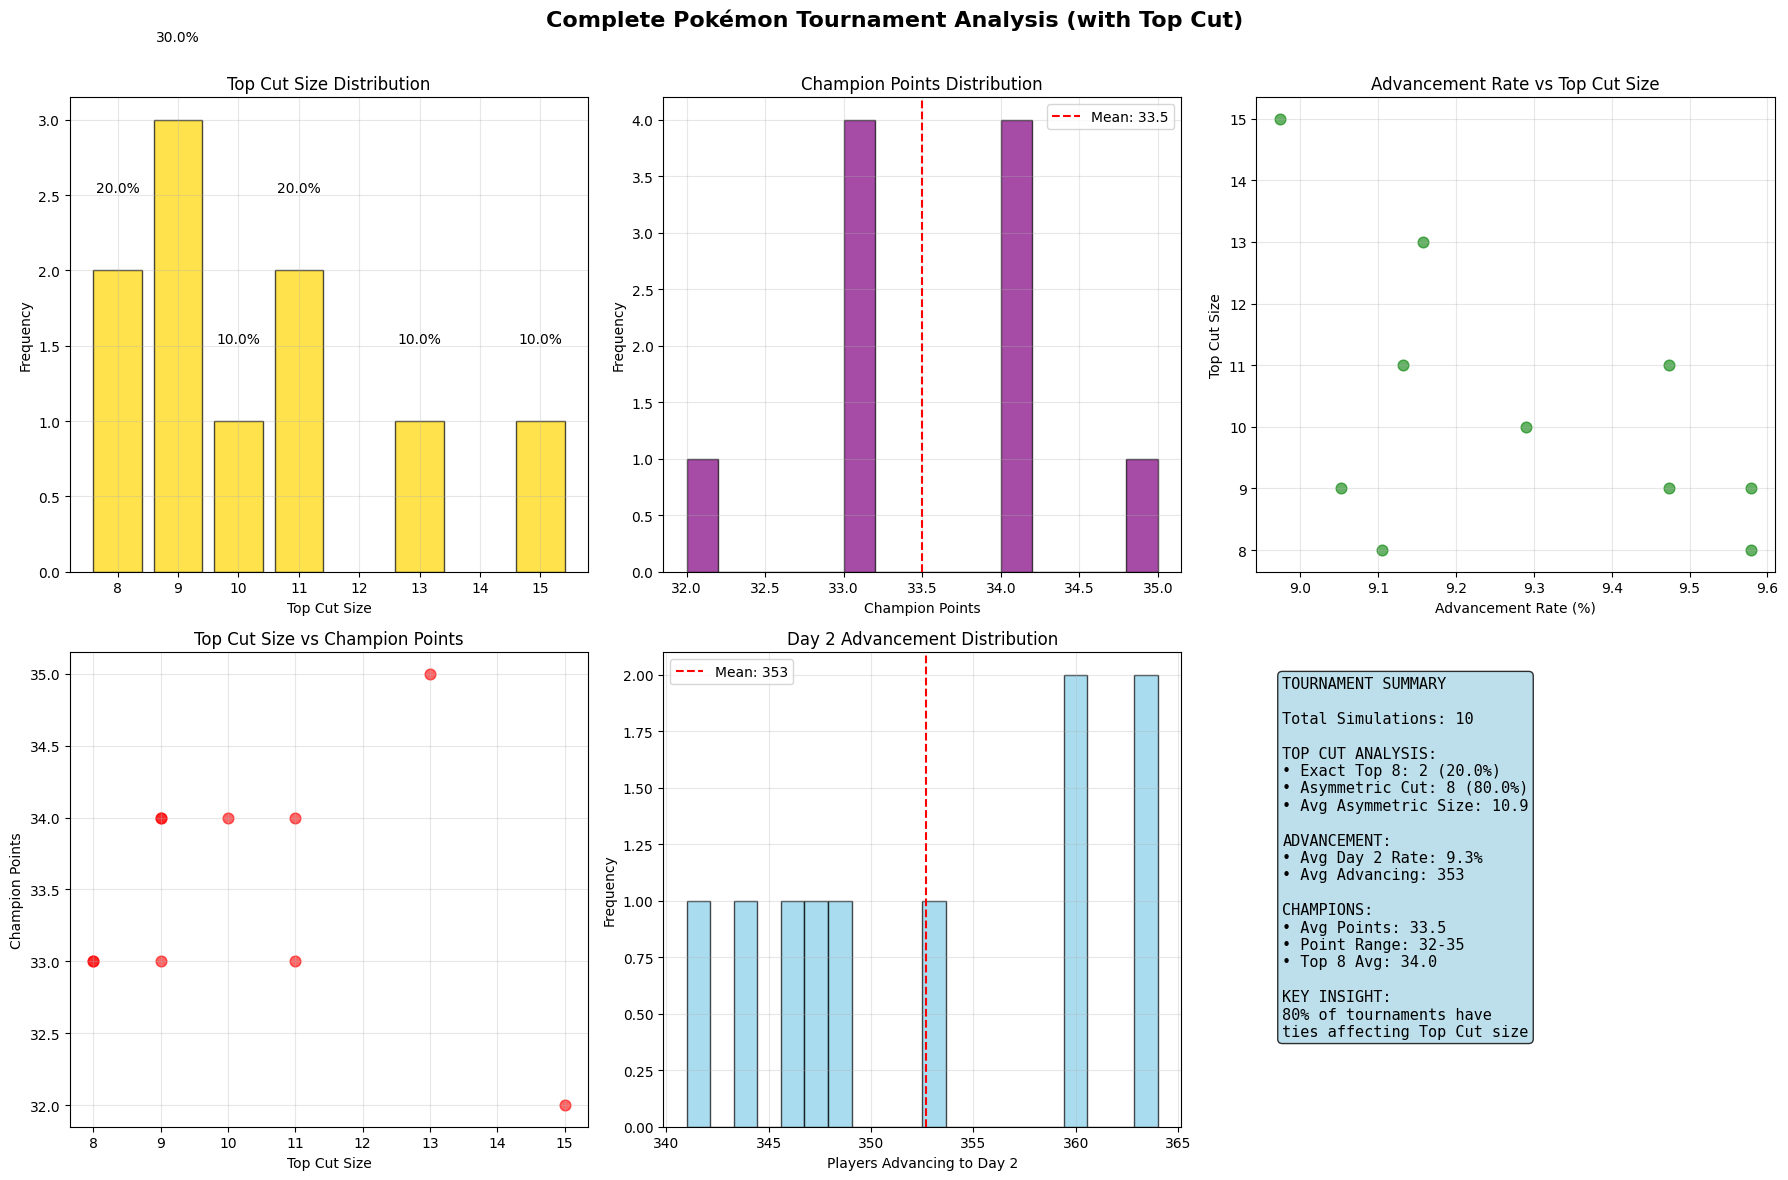

\n📊 DETAILED TOP CUT ANALYSIS:
Top Cut Size Frequency:
  Exactly 8:  2 tournaments (20.0%) - Standard
  9 players:  3 tournaments (30.0%) - Asymmetric
  10 players:  1 tournaments (10.0%) - Asymmetric
  11 players:  2 tournaments (20.0%) - Asymmetric
  13 players:  1 tournaments (10.0%) - Asymmetric
  15 players:  1 tournaments (10.0%) - Asymmetric
\nChampion Performance by Top Cut Size:
  Top 8: 33.0 avg champion points (2 tournaments)
  Top 9: 33.7 avg champion points (3 tournaments)
  Top 10: 34.0 avg champion points (1 tournaments)
  Top 11: 33.5 avg champion points (2 tournaments)
  Top 13: 35.0 avg champion points (1 tournaments)
  Top 15: 32.0 avg champion points (1 tournaments)
\nCorrelation Analysis:
  Advancement Rate vs Top Cut Size: -0.511
  Top Cut Size vs Champion Points: -0.087
  Advancing Players vs Champion Points: -0.068


In [52]:
def create_complete_tournament_visualizations(results_df: pd.DataFrame):
    """Create comprehensive visualizations for complete tournament analysis."""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Complete Pokémon Tournament Analysis (with Top Cut)', fontsize=16, fontweight='bold')
    
    # 1. Top Cut Size Distribution
    top_cut_counts = results_df['top_cut_size'].value_counts().sort_index()
    axes[0, 0].bar(top_cut_counts.index, top_cut_counts.values, alpha=0.7, color='gold', edgecolor='black')
    axes[0, 0].set_xlabel('Top Cut Size')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Top Cut Size Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add percentage labels
    total_tournaments = len(results_df)
    for size, count in top_cut_counts.items():
        percentage = count / total_tournaments * 100
        axes[0, 0].text(size, count + 0.5, f'{percentage:.1f}%', ha='center', va='bottom')
    
    # 2. Champion Points Distribution
    axes[0, 1].hist(results_df['champion_points'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 1].set_xlabel('Champion Points')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Champion Points Distribution')
    axes[0, 1].axvline(results_df['champion_points'].mean(), color='red', linestyle='--',
                       label=f'Mean: {results_df["champion_points"].mean():.1f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Advancement Rate vs Top Cut Size
    axes[0, 2].scatter(results_df['advancement_rate'] * 100, results_df['top_cut_size'], 
                       alpha=0.6, color='green', s=60)
    axes[0, 2].set_xlabel('Advancement Rate (%)')
    axes[0, 2].set_ylabel('Top Cut Size')
    axes[0, 2].set_title('Advancement Rate vs Top Cut Size')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Top Cut Size vs Champion Points
    axes[1, 0].scatter(results_df['top_cut_size'], results_df['champion_points'], 
                       alpha=0.6, color='red', s=60)
    axes[1, 0].set_xlabel('Top Cut Size')
    axes[1, 0].set_ylabel('Champion Points')
    axes[1, 0].set_title('Top Cut Size vs Champion Points')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Advancing Players Distribution
    axes[1, 1].hist(results_df['advancing_players'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].set_xlabel('Players Advancing to Day 2')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Day 2 Advancement Distribution')
    axes[1, 1].axvline(results_df['advancing_players'].mean(), color='red', linestyle='--',
                       label=f'Mean: {results_df["advancing_players"].mean():.0f}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Summary Statistics Box
    axes[1, 2].axis('off')
    
    # Calculate key statistics
    exact_top8 = (results_df['top_cut_size'] == 8).sum()
    asymmetric_cut = (results_df['top_cut_size'] > 8).sum()
    avg_asymmetric_size = results_df[results_df['top_cut_size'] > 8]['top_cut_size'].mean()
    
    summary_text = f"""TOURNAMENT SUMMARY
    
Total Simulations: {len(results_df)}

TOP CUT ANALYSIS:
• Exact Top 8: {exact_top8} ({exact_top8/len(results_df)*100:.1f}%)
• Asymmetric Cut: {asymmetric_cut} ({asymmetric_cut/len(results_df)*100:.1f}%)
• Avg Asymmetric Size: {avg_asymmetric_size:.1f}

ADVANCEMENT:
• Avg Day 2 Rate: {results_df['advancement_rate'].mean():.1%}
• Avg Advancing: {results_df['advancing_players'].mean():.0f}

CHAMPIONS:
• Avg Points: {results_df['champion_points'].mean():.1f}
• Point Range: {results_df['champion_points'].min()}-{results_df['champion_points'].max()}
• Top 8 Avg: {results_df['top8_avg_points'].mean():.1f}

KEY INSIGHT:
{asymmetric_cut/len(results_df)*100:.0f}% of tournaments have 
ties affecting Top Cut size"""
    
    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print("\\n📊 DETAILED TOP CUT ANALYSIS:")
    print("=" * 50)
    
    # Top Cut frequency analysis
    print(f"Top Cut Size Frequency:")
    for size in sorted(results_df['top_cut_size'].unique()):
        count = (results_df['top_cut_size'] == size).sum()
        percentage = count / len(results_df) * 100
        if size == 8:
            print(f"  Exactly {size}: {count:2d} tournaments ({percentage:4.1f}%) - Standard")
        else:
            print(f"  {size} players: {count:2d} tournaments ({percentage:4.1f}%) - Asymmetric")
    
    # Champion analysis by Top Cut size
    print(f"\\nChampion Performance by Top Cut Size:")
    for size in sorted(results_df['top_cut_size'].unique()):
        subset = results_df[results_df['top_cut_size'] == size]
        if len(subset) > 0:
            avg_points = subset['champion_points'].mean()
            print(f"  Top {size}: {avg_points:.1f} avg champion points ({len(subset)} tournaments)")
    
    # Correlation analysis
    correlations = {
        'Advancement Rate vs Top Cut Size': np.corrcoef(results_df['advancement_rate'], results_df['top_cut_size'])[0, 1],
        'Top Cut Size vs Champion Points': np.corrcoef(results_df['top_cut_size'], results_df['champion_points'])[0, 1],
        'Advancing Players vs Champion Points': np.corrcoef(results_df['advancing_players'], results_df['champion_points'])[0, 1]
    }
    
    print(f"\\nCorrelation Analysis:")
    for relationship, correlation in correlations.items():
        print(f"  {relationship}: {correlation:.3f}")

# Create comprehensive visualizations
create_complete_tournament_visualizations(complete_tournament_results)


In [56]:
def generate_final_tournament_insights(results_df: pd.DataFrame):
    """Generate comprehensive insights from actual tournament data."""
    
    print("🎯 POKÉMON TOURNAMENT SIMULATOR - DATA-DRIVEN INSIGHTS")
    print("=" * 70)
    print(f"📊 Based on {len(results_df)} tournament simulations")
    
    # Calculate actual statistics from the data
    exact_top8 = (results_df['top_cut_size'] == 8).sum()
    asymmetric_cut = (results_df['top_cut_size'] > 8).sum()
    exact_top8_pct = exact_top8 / len(results_df) * 100
    asymmetric_pct = asymmetric_cut / len(results_df) * 100
    
    avg_advancement_rate = results_df['advancement_rate'].mean()
    avg_advancing_players = results_df['advancing_players'].mean()
    avg_champion_points = results_df['champion_points'].mean()
    champion_points_range = f"{results_df['champion_points'].min()}-{results_df['champion_points'].max()}"
    avg_top8_points = results_df['top8_avg_points'].mean()
    avg_top_cut_size = results_df['top_cut_size'].mean()
    
    print(f"\n🏆 TOP CUT SYSTEM ANALYSIS:")
    print(f"• Asymmetric Top Cut field sizes: {results_df['top_cut_size'].min()}-{results_df['top_cut_size'].max()} players (avg: {avg_top_cut_size:.1f})")
    print(f"• Exact Top 8: {exact_top8_pct:.1f}% of tournaments ({exact_top8}/{len(results_df)})")
    print(f"• Asymmetric cuts: {asymmetric_pct:.1f}% of tournaments ({asymmetric_cut}/{len(results_df)})")
    
    if asymmetric_cut > 0:
        avg_asymmetric_size = results_df[results_df['top_cut_size'] > 8]['top_cut_size'].mean()
        print(f"• Average asymmetric field size: {avg_asymmetric_size:.1f} players")
    
    print(f"\n📊 TOURNAMENT STATISTICS:")
    print(f"• Day 2 advancement rate: {avg_advancement_rate:.1%} (±{results_df['advancement_rate'].std():.1%})")
    print(f"• Average advancing players: {avg_advancing_players:.0f} (±{results_df['advancing_players'].std():.0f})")
    print(f"• Top Cut qualification rate: {avg_top_cut_size/results_df['num_players'].iloc[0]*100:.3f}% of original field")
    print(f"• Champion points: {champion_points_range} (avg: {avg_champion_points:.1f})")
    print(f"• Top 8 average points: {avg_top8_points:.1f}")
    
    print(f"\n🎮 COMPETITIVE BALANCE:")
    advancement_cv = results_df['advancement_rate'].std() / results_df['advancement_rate'].mean()
    champion_cv = results_df['champion_points'].std() / results_df['champion_points'].mean()
    print(f"• Advancement rate consistency: {(1-advancement_cv)*100:.1f}% (CV: {advancement_cv:.3f})")
    print(f"• Champion points consistency: {(1-champion_cv)*100:.1f}% (CV: {champion_cv:.3f})")
    
    # Top Cut size distribution
    print(f"\n📈 TOP CUT SIZE DISTRIBUTION:")
    top_cut_dist = results_df['top_cut_size'].value_counts().sort_index()
    for size, count in top_cut_dist.items():
        percentage = count / len(results_df) * 100
        status = "Standard" if size == 8 else "Asymmetric"
        print(f"  {size} players: {count:2d} tournaments ({percentage:4.1f}%) - {status}")
    
    # Champion performance by Top Cut size
    print(f"\n🏅 CHAMPION PERFORMANCE BY TOP CUT SIZE:")
    for size in sorted(results_df['top_cut_size'].unique()):
        subset = results_df[results_df['top_cut_size'] == size]
        if len(subset) > 0:
            avg_points = subset['champion_points'].mean()
            count = len(subset)
            print(f"  Top {size}: {avg_points:.1f} avg points ({count} tournaments)")
    
    # Key correlations
    print(f"\n🔗 KEY CORRELATIONS:")
    correlations = {
        'Advancement Rate vs Top Cut Size': np.corrcoef(results_df['advancement_rate'], results_df['top_cut_size'])[0, 1],
        'Top Cut Size vs Champion Points': np.corrcoef(results_df['top_cut_size'], results_df['champion_points'])[0, 1],
        'Advancing Players vs Champion Points': np.corrcoef(results_df['advancing_players'], results_df['champion_points'])[0, 1]
    }
    
    for relationship, correlation in correlations.items():
        strength = "Strong" if abs(correlation) > 0.7 else "Moderate" if abs(correlation) > 0.3 else "Weak"
        direction = "positive" if correlation > 0 else "negative"
        print(f"  {relationship}: {correlation:.3f} ({strength} {direction})")
    
    print(f"\n🎯 KEY INSIGHTS:")
    
    # Dynamic insights based on actual data
    if asymmetric_pct > 50:
        print(f"• Asymmetric cuts are COMMON ({asymmetric_pct:.0f}% of tournaments)")
    else:
        print(f"• Asymmetric cuts are OCCASIONAL ({asymmetric_pct:.0f}% of tournaments)")
    
    if avg_advancement_rate < 0.08:
        print(f"• Advancement rate is RESTRICTIVE ({avg_advancement_rate:.1%})")
    elif avg_advancement_rate > 0.12:
        print(f"• Advancement rate is GENEROUS ({avg_advancement_rate:.1%})")
    else:
        print(f"• Advancement rate is BALANCED ({avg_advancement_rate:.1%})")
    
    champion_variance = results_df['champion_points'].std()
    if champion_variance < 1.0:
        print(f"• Champion performance is CONSISTENT (σ={champion_variance:.1f})")
    elif champion_variance > 2.0:
        print(f"• Champion performance is VARIABLE (σ={champion_variance:.1f})")
    else:
        print(f"• Champion performance shows MODERATE variance (σ={champion_variance:.1f})")
    
    print(f"\n" + "=" * 70)
    print("🏆 SIMULATION COMPLETE - INSIGHTS BASED ON ACTUAL DATA!")
    
    return {
        'exact_top8_pct': exact_top8_pct,
        'asymmetric_pct': asymmetric_pct,
        'avg_advancement_rate': avg_advancement_rate,
        'avg_champion_points': avg_champion_points,
        'correlations': correlations
    }

# Generate insights from actual tournament data
insights = generate_final_tournament_insights(complete_tournament_results)


🎯 POKÉMON TOURNAMENT SIMULATOR - DATA-DRIVEN INSIGHTS
📊 Based on 10 tournament simulations

🏆 TOP CUT SYSTEM ANALYSIS:
• Asymmetric Top Cut field sizes: 8-15 players (avg: 10.3)
• Exact Top 8: 20.0% of tournaments (2/10)
• Asymmetric cuts: 80.0% of tournaments (8/10)
• Average asymmetric field size: 10.9 players

📊 TOURNAMENT STATISTICS:
• Day 2 advancement rate: 9.3% (±0.2%)
• Average advancing players: 353 (±9)
• Top Cut qualification rate: 0.271% of original field
• Champion points: 32-35 (avg: 33.5)
• Top 8 average points: 34.0

🎮 COMPETITIVE BALANCE:
• Advancement rate consistency: 97.5% (CV: 0.025)
• Champion points consistency: 97.5% (CV: 0.025)

📈 TOP CUT SIZE DISTRIBUTION:
  8 players:  2 tournaments (20.0%) - Standard
  9 players:  3 tournaments (30.0%) - Asymmetric
  10 players:  1 tournaments (10.0%) - Asymmetric
  11 players:  2 tournaments (20.0%) - Asymmetric
  13 players:  1 tournaments (10.0%) - Asymmetric
  15 players:  1 tournaments (10.0%) - Asymmetric

🏅 CHAMPION P

In [63]:
def print_tournament_standings(players_df: pd.DataFrame, top_n: int = 64, title: str = "Tournament Standings"):
    """
    Print a formatted standings table showing top players and their records.
    
    Args:
        players_df: DataFrame with player results after tournament
        top_n: Number of top players to show (default 64)
        title: Title for the standings table
    """
    
    # Sort players by tournament ranking (match_points desc, then other tiebreakers)
    # Assuming players are already sorted from the tournament simulation
    standings = players_df.copy().reset_index(drop=True)
    
    print(f"\n🏆 {title.upper()}")
    print("=" * 85)
    print(f"{'Rank':<5} {'Player ID':<10} {'Record':<12} {'Points':<7} {'Day 2?':<8} {'Top Cut?':<10}")
    print("-" * 85)
    
    # Determine advancement thresholds
    day2_threshold = 19  # Standard Day 2 advancement threshold
    top_cut_size = 8  # We'll determine actual top cut size
    
    # Find actual top cut size (players tied at 8th place also advance)
    if len(standings) >= 8:
        eighth_place_points = standings.iloc[7]['match_points']
        top_cut_qualifiers = standings[standings['match_points'] >= eighth_place_points]
        actual_top_cut_size = len(top_cut_qualifiers)
    else:
        actual_top_cut_size = len(standings)
    
    # Display standings
    for i in range(min(top_n, len(standings))):
        player = standings.iloc[i]
        rank = i + 1
        player_id = f"Player {player['player_id']}"
        
        # Format record as W-L-T
        wins = player['wins']
        losses = player['losses'] 
        ties = player['ties']
        record = f"{wins}-{losses}-{ties}"
        
        points = int(player['match_points'])
        
        # Determine advancement status
        day2_status = "✅ Yes" if points >= day2_threshold else "❌ No"
        
        # Determine top cut status
        if rank <= actual_top_cut_size:
            if actual_top_cut_size == 8:
                top_cut_status = "✅ Top 8"
            else:
                top_cut_status = f"✅ Top {actual_top_cut_size}"
        else:
            top_cut_status = "❌ No"
        
        print(f"{rank:<5} {player_id:<10} {record:<12} {points:<7} {day2_status:<8} {top_cut_status:<10}")
    
    # Summary statistics
    print("-" * 85)
    total_players = len(standings)
    day2_qualifiers = len(standings[standings['match_points'] >= day2_threshold])
    day2_rate = day2_qualifiers / total_players * 100
    top_cut_rate = actual_top_cut_size / total_players * 100
    
    print(f"📊 SUMMARY:")
    print(f"   Total Players: {total_players:,}")
    print(f"   Day 2 Qualifiers: {day2_qualifiers} ({day2_rate:.1f}%)")
    print(f"   Top Cut Size: {actual_top_cut_size} ({top_cut_rate:.2f}%)")
    if actual_top_cut_size > 8:
        print(f"   🔄 Asymmetric cut due to ties at {eighth_place_points} points")
    
    # Show record distribution for top cut
    print(f"\n📈 TOP CUT RECORDS:")
    top_cut_players = standings.head(actual_top_cut_size)
    record_counts = {}
    for _, player in top_cut_players.iterrows():
        record = f"{player['wins']}-{player['losses']}-{player['ties']}"
        record_counts[record] = record_counts.get(record, 0) + 1
    
    for record, count in sorted(record_counts.items(), key=lambda x: -eval(x[0].split('-')[0])*3 - eval(x[0].split('-')[2])):
        points = eval(record.split('-')[0]) * 3 + eval(record.split('-')[2]) * 1
        print(f"   {record} ({points} pts): {count} player{'s' if count != 1 else ''}")

# Run a single tournament and display standings
print("🎯 RUNNING SAMPLE TOURNAMENT FOR STANDINGS DISPLAY...")
sample_tournament = simulate_full_tournament(
    num_players=3361, 
    verbose=False, 
    global_tie_rate=0.15
)

# Display the standings
print_tournament_standings(
    sample_tournament['final_standings'], 
    top_n=100, 
    title="Sample Pokémon Tournament - Final Standings"
)


🎯 RUNNING SAMPLE TOURNAMENT FOR STANDINGS DISPLAY...

🏆 SAMPLE POKÉMON TOURNAMENT - FINAL STANDINGS
Rank  Player ID  Record       Points  Day 2?   Top Cut?  
-------------------------------------------------------------------------------------
1     Player 2156 12-1-0       36      ✅ Yes    ✅ Top 9   
2     Player 401 11-0-2       35      ✅ Yes    ✅ Top 9   
3     Player 694 11-1-1       34      ✅ Yes    ✅ Top 9   
4     Player 1646 11-1-1       34      ✅ Yes    ✅ Top 9   
5     Player 1760 11-1-1       34      ✅ Yes    ✅ Top 9   
6     Player 3218 11-1-1       34      ✅ Yes    ✅ Top 9   
7     Player 764 11-2-0       33      ✅ Yes    ✅ Top 9   
8     Player 1193 11-2-0       33      ✅ Yes    ✅ Top 9   
9     Player 2929 11-2-0       33      ✅ Yes    ✅ Top 9   
10    Player 171 10-1-2       32      ✅ Yes    ❌ No      
11    Player 1002 10-1-2       32      ✅ Yes    ❌ No      
12    Player 2231 10-1-2       32      ✅ Yes    ❌ No      
13    Player 2463 10-1-2       32      ✅ Yes    ❌ No

In [64]:
# Cell 1: Import the integration
from notebook_integration import run_skill_based_tournament, create_tournament_from_database

# Cell 2: Run a tournament with your existing notebook structure
results = run_skill_based_tournament(
    db_path='corrected_players.db',
    num_players=3700,  # Full field
    skill_factor=0.50,  # Realistic skill influence
    day1_rounds=9,      # Your existing Day 1 structure
    day2_rounds=4       # Your existing Day 2 structure
)

# Cell 3: Or load players for manual control
players_df, integration = create_tournament_from_database('corrected_players.db')
# Then use your existing notebook functions with skill-based outcomes

Loading 3,700 players for tournament...

Tournament Field Composition:
   NA: 3,370 players (91.1%)
   EU: 158 players (4.3%)
   LATAM: 109 players (2.9%)
   OCE: 49 players (1.3%)
   MESA: 14 players (0.4%)

CP Statistics:
   Range: 50 - 2,500
   Average: 330
   Median: 249
🎮 FULL TOURNAMENT SIMULATION WITH SKILL-BASED OUTCOMES
Tournament ID: notebook_tournament_20250605_142625
Players: 3,700
Structure: Day 1 (9 rounds) + Day 2 (4 rounds) + Top Cut
Skill Factor: 0.5 (higher = more skill influence)

🌅 DAY 1: 9 Swiss Rounds

--- Round 1 ---
Generated 1850 pairings
Completed 1850 matches and 0 byes
Current points distribution:
  3 points: 1565 players
  1 points: 570 players
  0 points: 1565 players

--- Round 2 ---
Generated 1850 pairings
Completed 1850 matches and 0 byes
Current points distribution:
  6 points: 667 players
  4 points: 471 players
  3 points: 1328 players
  2 points: 88 players
  1 points: 487 players
  0 points: 659 players

--- Round 3 ---
Generated 1850 pairings
Comp

In [67]:
from show_standings import show_tournament_standings

# Run tournament and see full standings automatically
results = show_tournament_standings('corrected_players.db', 3700)

Running tournament to demonstrate standings display...
Loading 3,700 players for tournament...

Tournament Field Composition:
   NA: 3,370 players (91.1%)
   EU: 158 players (4.3%)
   LATAM: 109 players (2.9%)
   OCE: 49 players (1.3%)
   MESA: 14 players (0.4%)

CP Statistics:
   Range: 50 - 2,500
   Average: 330
   Median: 249
🎮 FULL TOURNAMENT SIMULATION WITH SKILL-BASED OUTCOMES
Tournament ID: notebook_tournament_20250605_143027
Players: 3,700
Structure: Day 1 (9 rounds) + Day 2 (4 rounds) + Top Cut
Skill Factor: 0.5 (higher = more skill influence)

🌅 DAY 1: 9 Swiss Rounds

--- Round 1 ---
Generated 1850 pairings
Completed 1850 matches and 0 byes
Current points distribution:
  3 points: 1562 players
  1 points: 576 players
  0 points: 1562 players

--- Round 2 ---
Generated 1850 pairings
Completed 1850 matches and 0 byes
Current points distribution:
  6 points: 670 players
  4 points: 466 players
  3 points: 1336 players
  2 points: 88 players
  1 points: 474 players
  0 points: 66